In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Normalize
from PIL import Image
import scipy.io as sio

from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [2]:
def read_show_save(chip:CHIP,filename=None,vmin=200,vmax=800):
    res_matrix = chip.read_crossbar2(row_index=list(range(256)),col_index=list(range(256)),
                                 read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=1)
    if filename is not None:
        np.save(filename,res_matrix)
    cmap = plt.cm.viridis
    norm = Normalize(vmin=vmin, vmax=vmax)
    im = plt.imshow(res_matrix, cmap=cmap,norm=norm)
    cbar = plt.colorbar(im)
    cbar.set_label("us")
    plt.show()
    return res_matrix

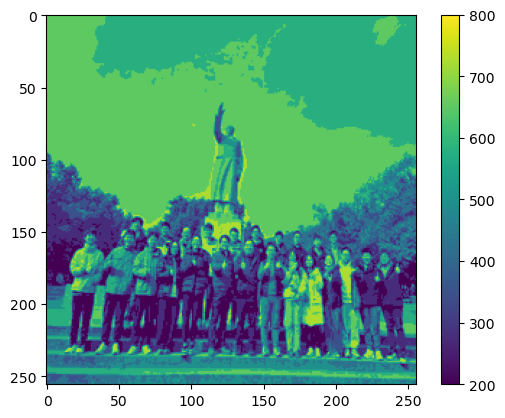

[[650 650 650 ... 575 575 575]
 [650 650 650 ... 575 575 575]
 [650 650 650 ... 575 575 575]
 ...
 [425 425 350 ... 500 500 425]
 [350 350 350 ... 425 425 425]
 [425 350 425 ... 500 425 425]]


In [3]:
mat_file = sio.loadmat('images/image_gray.mat')
target = np.array(mat_file["gray_matrix"])
target = (target/32).astype(int)
# print(np.sum(target>6))
target = (target/8*600)+200
target = target.astype(int)

cmap = plt.cm.viridis
norm = Normalize(vmin=200, vmax=800)
im = plt.imshow(target, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
plt.show()
print(target)

In [4]:
def get_tgv(cond):
    slope, intercept = 0.0008161013623861578, 1.052245944709637
    return slope*np.array(cond) + intercept

In [5]:
x = [i for i in range(200,800,50)]
print(get_tgv(x))

[1.21546622 1.25627129 1.29707635 1.33788142 1.37868649 1.41949156
 1.46029663 1.50110169 1.54190676 1.58271183 1.6235169  1.66432197]


In [6]:
chip=CHIP(PS(host="192.168.1.10", port = 7, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 49662


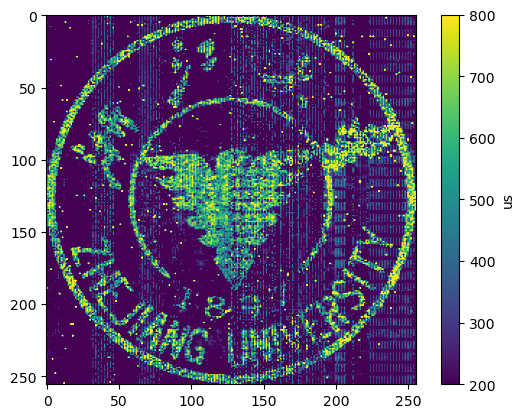

In [7]:
res_matrix = read_show_save(chip,"result/gray_img/base.npy",vmin=200,vmax=800)

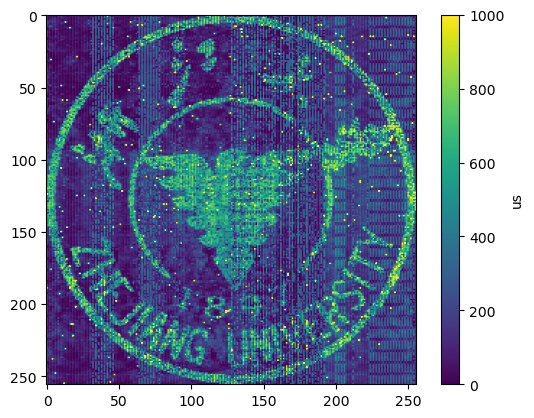

In [8]:
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(res_matrix, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

需要读65536个点


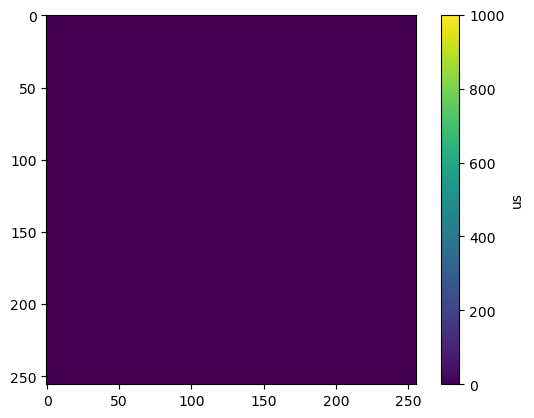

In [15]:
res_matrix_base = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(res_matrix_base, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

需要读65536个点


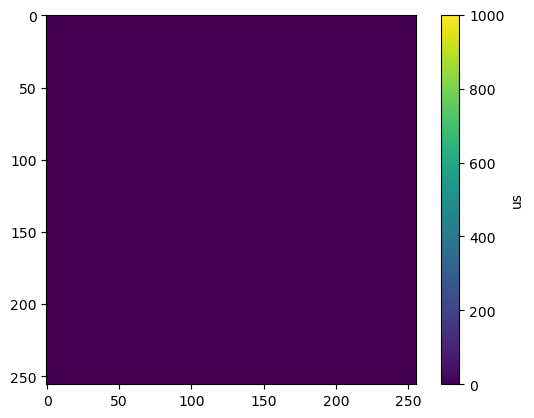

In [16]:

res_matrix2 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(res_matrix2, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

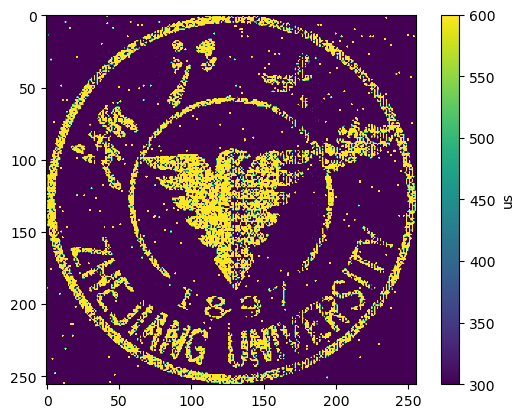

In [20]:
cmap = plt.cm.viridis
norm = Normalize(vmin=300, vmax=600)
im = plt.imshow(chip.voltage_to_cond(res_matrix2-res_matrix_base), cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

In [9]:
img = Image.open('images/zju.png').convert('L')
img = img.resize((256, 256), Image.LANCZOS)

img = np.array(img)
img = np.where(img >= 128, 0, 1).astype(np.uint8)

condition_set = (res_matrix2 < 800) & (img > 0.5)
is_set = True
chip.write_point2(crossbar=condition_set,write_voltage=2,tg=2,pulse_width=100e-6,set_device=is_set)


condition_reset = (res_matrix2 > 200) & (img < 0.5)
is_set = False
chip.write_point2(crossbar=condition_reset,write_voltage=4,tg=5,pulse_width=1000e-6,set_device=is_set)

需要写6808个点
需要写2866个点


需要读65536个点


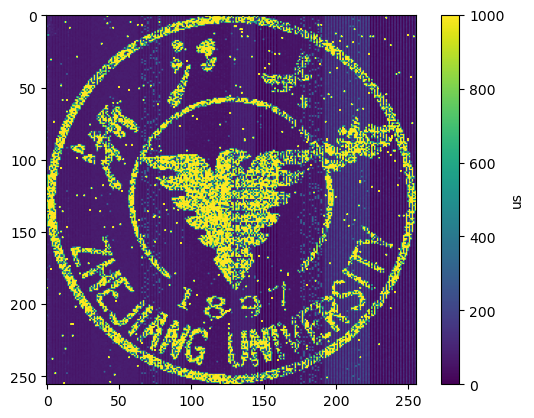

In [10]:
res_matrix2 = chip.read_point2(crossbar=np.ones((256,256)),
                                read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=1)
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(res_matrix2, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

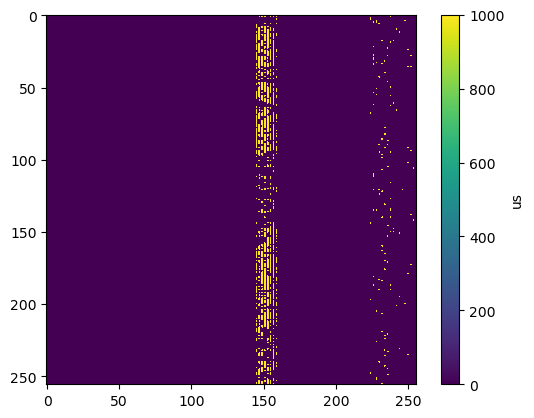

In [14]:
cmap = plt.cm.viridis
norm = Normalize(vmin=0, vmax=1000)
im = plt.imshow(res_matrix2-res_matrix_base, cmap=cmap,norm=norm)
cbar = plt.colorbar(im)
cbar.set_label("us")
plt.show()

需要写5066个点


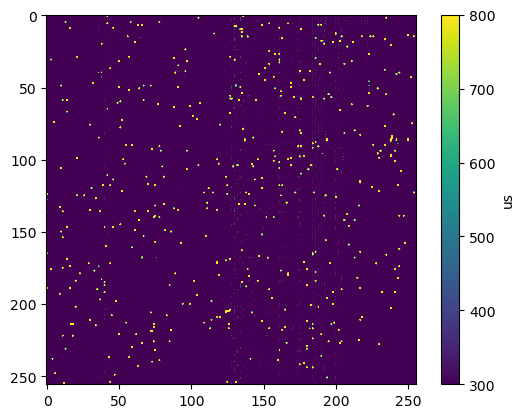

In [ ]:
# 先reset,差距大于75/2
condition_reset = (res_matrix>250) & (res_matrix<700)
is_set = False
chip.write_point2(device_array=condition_reset,write_voltage=4,tg=5,pulse_width=1000e-6,set_device=is_set)
res_matrix = read_show_save(chip,None,vmin=300,vmax=800)

In [33]:
states = [int(200+i*75) for i in range(8)]
print(states)

[200, 275, 350, 425, 500, 575, 650, 725]


需要写1218个点


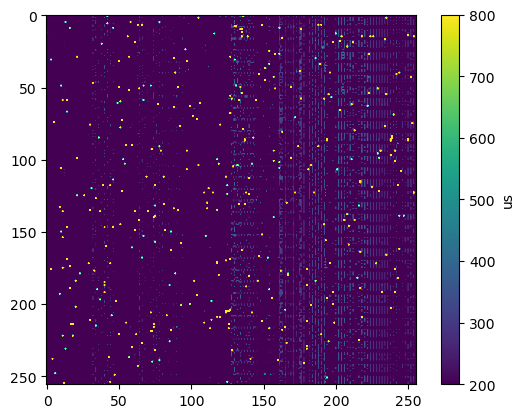

In [42]:
# 先reset,差距大于75/2
condition_reset = res_matrix>(target+75/2)
is_set = False
chip.write_point2(device_array=condition_reset,write_voltage=1.6,tg=5,pulse_width=300e-6,set_device=is_set)
tmp = read_show_save(chip,None,vmin=200,vmax=800)

In [ ]:
for state in states:
    target_mask = target==state
    condition_set = (res_matrix < 800) & (target_mask > 0.5)
    # 电导>200,且img为0,就需要reset
    condition_reset = (res_matrix > 200) & (img < 0.5)

    is_set = True
    chip.write_point2(device_array=condition_set,write_voltage=2,tg=2,pulse_width=100e-6,set_device=is_set)
condition_reset = res_matrix >200
is_set = False
chip.write_point2(device_array=condition_reset,write_voltage=1.6,tg=5,pulse_width=300e-6,set_device=is_set)

In [ ]:
print(np.sum(target==201))

In [ ]:
# 电导<800,且img为1,就需要set
condition_set = (res_matrix < 800) & (img > 0.5)
# 电导>200,且img为0,就需要reset
condition_reset = (res_matrix > 200) & (img < 0.5)

is_set = True
chip.write_point2(device_array=condition_set,write_voltage=2,tg=2,pulse_width=100e-6,set_device=is_set)